# S2S Forecast verification with `climpred`

This notebook is part of the [tutorials](https://www.cgd.ucar.edu/events/2021/asp-colloquia/tutorials.html) in the [ASP summer school](https://www.cgd.ucar.edu/events/2021/asp-colloquia/).

In the [S2S verification tutorial](https://docs.google.com/document/d/1nQOyjjAjdqN2sl3IeJYCytCo4l_49GW6fMgkKjsnsCc/edit),
we use `climpred` https://climpred.readthedocs.io/en/stable/ to verify subseasonal-to-seasonal (S2S) forecasts against observations.

---

Table of Contents:

- `climpred` S2S on country data
    - deterministic metric: `rmse`
    - subselect initializations
    - probabilistic metric: `rps`
- `climpred` S2S on big (geospatial) data
    - probabilistic metric: `rps`

---

Other resources:

- `xarray`: working horse for geospatial data in python
    - documentation: xarray.pydata.org/
    - tutorial: https://xarray-contrib.github.io/xarray-tutorial/
- `xskillscore`: is built on top of `xarray` and provides `metric`s to `climpred`
    - documentation: https://xskillscore.readthedocs.io/en/stable/
    - quick-start: https://mybinder.org/v2/gh/xarray-contrib/xskillscore/master?urlpath=lab
- `climpred`:
    - documentation: https://climpred.readthedocs.io/en/stable/
    - data model: https://climpred.readthedocs.io/en/stable/setting-up-data.html
    - classes: https://climpred.readthedocs.io/en/stable/prediction-ensemble-object.html
    - list of initialized public datasets to work with: https://climpred.readthedocs.io/en/stable/initialized-datasets.html
    - terminology: https://climpred.readthedocs.io/en/stable/terminology.html
    - alignment: https://climpred.readthedocs.io/en/stable/alignment.html

--- 

Usage questions? Consider...

- raising an [issue](https://github.com/pangeo-data/climpred/issues), which can be transferred to [discussions](https://github.com/pangeo-data/climpred/discussions)
- reaching out on [slack](asp2021-s2s.slack.com)

In [1]:
import numpy as np
import xarray as xr
import climpred
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
climpred.set_options(warn_for_failed_PredictionEnsemble_xr_call=False)

# Country data

In [2]:
#!ls /glade/campaign/mmm/c3we/jaye/S2S_zarr/OBS*

In [3]:
#!ls -all /glade/scratch/jaye/S2S_zarr/CPC.country.zarr

In [109]:
#!ls /glade/scratch/jaye/S2S_zarr

In [61]:
data_path = '/glade/scratch/jaye/S2S_zarr'

# load spatially aggregated data
model = 'ECMWF' # ECCC, NCEP  # forecast model
data = 'anom' # raw # anom means anomaly and means that climatology is removed
lead = 'daily' # biweekly  # lead aggregation
dim = 'country' # geospatial  # spatial aggregatation

init = xr.open_dataset(f'{data_path}/{model}.{data}.{lead}.{dim}.zarr', engine='zarr', decode_timedelta=False)#.drop('dayofyear')
obs = xr.open_dataset(f'{data_path}/CPC.{dim}.zarr', engine='zarr')#.drop('dayofyear')

In [50]:
# data_path = '/glade/campaign/mmm/c3we/jaye/S2S_zarr'
#obs = xr.open_dataset(f'{data_path}/OBS.{data}.{lead}.{dim}.zarr', engine='zarr').drop('dayofyear')

In [51]:
# alternatively with intake
#import intake
#cat = intake.open_catalog('ASP_data_catalog.yml')
#init = cat[model](data=data, lead=lead, dim=dim).to_dask()
#obs = cat['obs'](data=data, lead=lead, dim=dim).to_dask()

In [53]:
hind = climpred.HindcastEnsemble(init).add_observations(obs)

In [54]:
region = 'Germany' #'India'  # 'United States of America'
hind = hind.sel(region=region)[['t2m']].compute() # HindcastEnsemble behaves like xr.Dataset
# compute to get data into memory # only use dask when needed

In [55]:
# create 15D averages
def biweekly(init):
    """
    Create biweekly averages before creating `climpred.HindcastEnsemble`.
    Hence, we first create biweekly averages of the initialized forecasts over the `lead` dimension.
    Then we create biweekly averages in observations over the `time` dimension.

    When verifying total precipitation, do biweekly sums to the verification precip data.
    """
    if 'lead' in init.dims:
        init_w12 = init.sel(lead=range(1, 1 + 15)).mean(dim='lead', skipna=False)
        init_w34 = init.sel(lead=range(16, 16 + 15)).mean(dim='lead', skipna=False)
        init_w56 = init.sel(lead=range(31, 31 + 15)).mean(dim='lead', skipna=False)
        init_biweekly = xr.concat([init_w12, init_w34, init_w56], dim='lead')
        init_biweekly['lead'] = [1, 15, 31] # lead represents first day of biweekly aggregate
        init_biweekly['lead'].attrs['units'] = 'days'
        return init_biweekly
    elif 'time' in init.dims: # taking obs
        obs = init
        obs_biweekly = obs.rolling(time=15, center=False).mean()
        obs_biweekly = obs_biweekly.isel(time=slice(14, None)).assign_coords(time=obs.time.isel(time=slice(None, -14))) # time represents first day of biweekly aggregate
        return obs_biweekly

In [72]:
# choose one or the other: delete the other one

# map maps a function to each dataset
# hind = hind.map(biweekly) # biweekly aggregates

hind = hind.isel(lead=np.arange(1,init.lead.size,7))  # every 7th lead NOT aggregated

<AxesSubplot:xlabel='time', ylabel='t2m'>

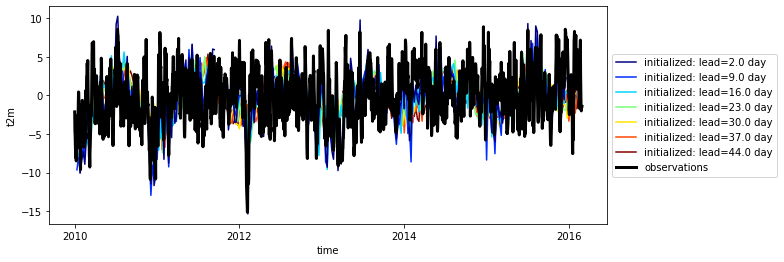

In [74]:
# plot temporal subset # if error with kind: #!conda install pandas!=1.3.0 -c conda-forge -y
hind.sel(init=slice('2010','2015')).sel(time=slice('2010','2016-02')).plot()

## Deterministic metric

For other deterministic metrics (like `pearson_r`, `spearmean_r`, `mae`, ...) check https://climpred.readthedocs.io/en/stable/metrics.html#deterministic

Here we use the root-mean-square-error RMSE:

- https://xskillscore.readthedocs.io/en/latest/api/xskillscore.rmse.html#xskillscore.rmse
- https://climpred.readthedocs.io/en/stable/metrics.html#root-mean-square-error-rmse

### Raw initialized skill

`HindcastEnsemble.verify()` [documentation](https://climpred.readthedocs.io/en/stable/api/climpred.classes.HindcastEnsemble.verify.html#climpred.classes.HindcastEnsemble.verify) is the most important `climpred` feature. It takes each `lead` from the `initialized` dataset with dimension `init` and matches the corresponding `observation`s `time`.

First, we take the RMSE between the ensemble member mean forecast and the observations by reducing the `init` dimension and aligning to the same initializations for all leads. All these keywords can be changed.

In [78]:
metric='rmse'

verify_kwargs = dict(metric=metric, # https://climpred.readthedocs.io/en/stable/metrics.html
                    comparison='e2o', # compare ensemble member mean to observations - https://climpred.readthedocs.io/en/stable/comparisons.html
                    dim='init', # reduce this dimension, equivalent to dim in xarray
                    alignment='maximize', # https://climpred.readthedocs.io/en/stable/alignment.html
                    keep_attrs=True, skipna=True) # passed to xs.metric

CPU times: user 8.83 s, sys: 7.29 ms, total: 8.84 s
Wall time: 8.87 s


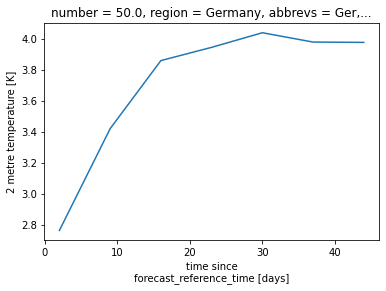

In [79]:
%time skill = hind.verify(**verify_kwargs)

skill.t2m.plot()

### Skill after bias reduction

Forecast models usually suffer a mean lead-time dependent bias towards the observations, which can be reduced by `HindcastEnsemble.remove_bias()` [[documentation](https://climpred.readthedocs.io/en/stable/bias_removal.html)].

In [80]:
# remove lead-time dependent bias based on monthly climatology
with climpred.set_options(seasonality='month'):
    hind_bias_reduced = hind.remove_bias('same_inits', cross_validate=False)

/glade/u/home/aspring/.conda/envs/s2s-climpred/lib/python3.8/site-packages/climpred/bias_removal.py:138: UserWarning: HindcastEnsemble.remove_bias() is still experimental and is only tested for annual leads. Please consider contributing to https://github.com/pangeo-data/climpred/issues/605
  warnings.warn(


In [81]:
# quick view
# hind_bias_reduced.sel(init=slice('2010','2015')).sel(time=slice('2010','2016-02')).plot()

CPU times: user 8.82 s, sys: 12.3 ms, total: 8.84 s
Wall time: 8.85 s


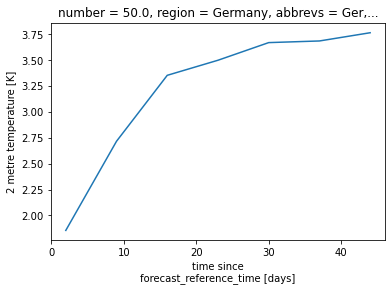

In [82]:
%time skill_bias_reduced = hind_bias_reduced.verify(**verify_kwargs)

skill_bias_reduced.t2m.plot(label='ACC after bias reduction')

We can also compare each forecast member individually `comparison='m2o'` (and not the ensemble mean forecast `e2o`). 

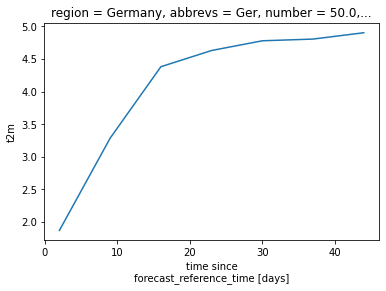

In [84]:
skill_bias_reduced_m = hind_bias_reduced.verify(metric=verify_kwargs['metric'], dim=['init','member'], skipna=verify_kwargs['skipna'],
                                                      comparison='m2o', alignment=verify_kwargs['alignment'])

# naturally RMSE increases / gets worse
skill_bias_reduced_m.t2m.plot(label='ACC after bias reduction each member forecast')

## `PerfectModel` skill

Let's also check the `PerfectModelEnsemble` skill [[documentation](https://climpred.readthedocs.io/en/stable/api.html#perfectmodelensemble)], i.e. when model tries to predict itself and one model member serves as observations: https://climpred.readthedocs.io/en/stable/terminology.html.

`PerfectModelEnsemble.verify()` [[documentation](https://climpred.readthedocs.io/en/stable/api/climpred.classes.PerfectModelEnsemble.verify.html#climpred.classes.PerfectModelEnsemble.verify)] follows a very similar API as `HindcastEnsemble.verify()`. 

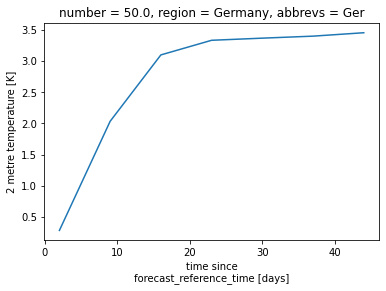

In [86]:
pm = climpred.PerfectModelEnsemble(hind.get_initialized())

verify_kwargs_pm = dict(metric=metric,
                        comparison='m2e',  # compare each member to ensemble mean forecast
                        dim=['init','member'], # reduce dims
                        keep_attrs=True, skipna=True)

pm_skill = pm.verify(**verify_kwargs_pm)
# perfectModel skill is often best
pm_skill.t2m.plot(label='PerfectModel ACC')

## Reference forecast

Skill of reference forecasts: https://climpred.readthedocs.io/en/stable/reference_forecast.html

- `persistence`: forecast initial conditions stay for all leads
- `climatology`: forecast mean conditions for each lead

In [87]:
skill_reference = hind_bias_reduced.verify(reference=['persistence','climatology'], **verify_kwargs)

## Overview

Text(0.5, 1.0, 'RMSE for Germany by forecast model ECMWF biweekly averaged')

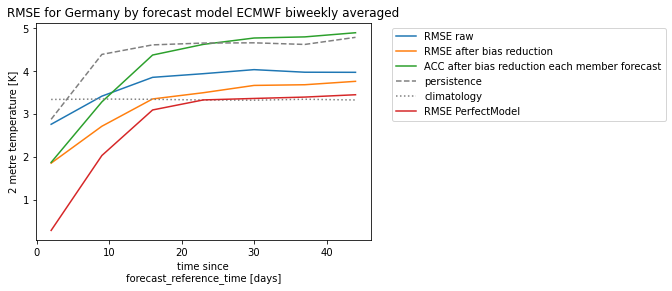

In [116]:
skill.t2m.plot(label=f'{metric.upper()} raw')
skill_bias_reduced.t2m.plot(label=f'{metric.upper()} after bias reduction')
skill_bias_reduced_m.t2m.plot(label='ACC after bias reduction each member forecast')
skill_reference.sel(skill='persistence').t2m.plot(c='gray',ls='--',label='persistence')
skill_reference.sel(skill='climatology').t2m.plot(c='gray',ls=':',label='climatology')
pm_skill.t2m.plot(label=f'{metric.upper()} PerfectModel')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title(f'{metric.upper()} for {region} by forecast model {model} biweekly averaged')

## calculate `init`-time dependent skill

`PredictionEnsemble` can be subselected with `sel` and `isel`.

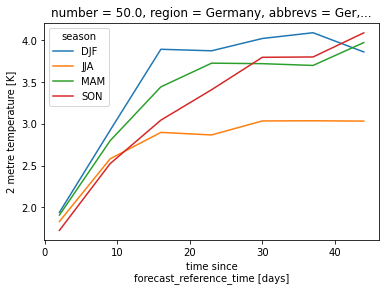

In [95]:
# until PredictionEnsemble.groupby.verify() is implemented: https://github.com/pangeo-data/climpred/issues/635
init_group = 'season' # month # dayofyear
skill_group = []
label_group = []
for group, hind_group in hind_bias_reduced.get_initialized().init.groupby(f'init.{init_group}'):
    skill_group.append(hind_bias_reduced.sel(init=hind_group).verify(**verify_kwargs))
    label_group.append(group)
skill_group = xr.concat(skill_group, init_group).assign_coords({init_group:label_group})

skill_group.t2m.plot(hue=init_group)

## Probabilistic

For other probabilistic metrics (like `rank_histogram`, `reliability`, `crps`, `crpss`, `brier_score`, ...) check https://climpred.readthedocs.io/en/stable/metrics.html#probabilistic

Here we use the ranked probability score RPS:
- https://xskillscore.readthedocs.io/en/latest/api/xskillscore.rps.html#xskillscore.rps
- https://climpred.readthedocs.io/en/stable/metrics.html#ranked-probability-score

---

`xs.rps` understands two kinds of inputs:

- deterministic, requires `category_edges` for counting how many `member`s are in each `category` (used here)
- probabilistic, requires `category` for forecast and observations and `input_distributions=p`

---

We create tercile category edges for the model and observations

Next, we show how using observations-based category edges for counting observations and using forecast-based category edges for counting the forecasts is a simple re-calibration method and improves/lowers `RPS`.

In [97]:
# tercile edges
q=[1/3, 2/3]
model_edges = hind_bias_reduced.get_initialized().groupby('init.month').quantile(q=q, dim=['member','init']).rename({'quantile':'category_edge'})
obs_edges = hind_bias_reduced.get_observations().groupby('time.month').quantile(q=q, dim='time').rename({'quantile':'category_edge'})

### Same `category_edges`

In [98]:
# same category_edges from observations used to bin forecast and observations
rps_kwargs_1e=dict(metric='rps', category_edges=obs_edges, dim=['member','init'], alignment='same_inits', comparison='m2o')
rps_raw_1e = hind.verify(**rps_kwargs_1e)
rps_bias_reduced_1e = hind_bias_reduced.verify(**rps_kwargs_1e)

### Different `category_edges`

In [99]:
# use category_edges from forecast to bin forecast and from observations to bin observations
rps_kwargs_2e=dict(metric='rps', category_edges=(obs_edges, model_edges), dim=['member','init'], alignment='same_inits', comparison='m2o')
rps_raw_2e = hind.verify(**rps_kwargs_2e)
rps_bias_reduced_2e = hind_bias_reduced.verify(**rps_kwargs_2e)

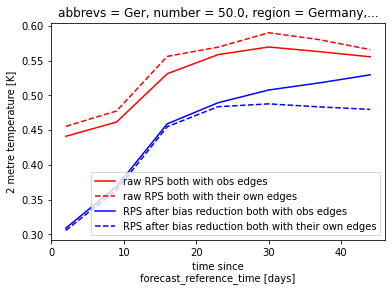

In [100]:
rps_raw_1e.t2m.plot(c='r',label='raw RPS both with obs edges')
rps_raw_2e.t2m.plot(c='r',ls='--',label='raw RPS both with their own edges')
rps_bias_reduced_1e.t2m.plot(c='b',label='RPS after bias reduction both with obs edges')
rps_bias_reduced_2e.t2m.plot(c='b',ls='--',label='RPS after bias reduction both with their own edges')
plt.legend()

### PerfectModel

Let's also check the PerfectModel `RPS`, i.e. when model tries to predict itself.

In [101]:
pm = climpred.PerfectModelEnsemble(hind.get_initialized())

In [102]:
rps_kwargs_pm = rps_kwargs_1e.copy()
rps_kwargs_pm['comparison']='m2m'
del rps_kwargs_pm['alignment']
# need to redo category_edges matching the initialized dataset
rps_kwargs_pm['category_edges'] = pm.get_initialized().groupby('init.month').quantile(q=q, dim=['init','member']).rename({'quantile':'category_edge'}).sel(month=pm.get_initialized().init.dt.month)

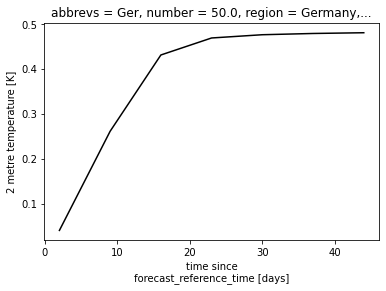

In [103]:
rps_pm = pm.verify(**rps_kwargs_pm)
rps_pm.t2m.plot(c='k', label='PerfectModel RPS')

### Climatology forecast

`.verify(reference=['climatology'],...)` does not work for `rps`. Therefore, we manually create a deterministic 3 member fake initialized dataset and verify its skill.

In [104]:
# create deterministic climatology forecast based on forecast distribution
tercile_clim_forecast = xr.ones_like(hind_bias_reduced.get_initialized().isel(member=0, drop=True)) * model_edges.sel(month=hind_bias_reduced.get_initialized().init.dt.month).isel(category_edge=[0,0,1]).rename({'category_edge':'member'})
tercile_clim_forecast = tercile_clim_forecast.assign_coords(member=[0.9,1.1,1.1])
tercile_clim_forecast = (tercile_clim_forecast * tercile_clim_forecast.member).assign_coords(member=['below normal','near normal','above normal'])

In [105]:
# create deterministic climatology forecast based on obs distribution
tercile_clim_obs_forecast = xr.ones_like(hind_bias_reduced.get_initialized().isel(member=0, drop=True)) * obs_edges.sel(month=hind_bias_reduced.get_initialized().init.dt.month).isel(category_edge=[0,0,1]).rename({'category_edge':'member'})
tercile_clim_obs_forecast = tercile_clim_obs_forecast.assign_coords(member=[0.9,1.1,1.1])
tercile_clim_obs_forecast = (tercile_clim_obs_forecast * tercile_clim_obs_forecast.member).assign_coords(member=['below normal','near normal','above normal'])

In [106]:
# calculate climatology skill with HindcastEnsemble, not reference
clim_rps_m1e = climpred.HindcastEnsemble(tercile_clim_forecast).add_observations(hind_bias_reduced.get_observations()).verify(**rps_kwargs_1e)
clim_rps_m2e = climpred.HindcastEnsemble(tercile_clim_forecast).add_observations(hind_bias_reduced.get_observations()).verify(**rps_kwargs_2e)
clim_rps_o1 = climpred.HindcastEnsemble(tercile_clim_obs_forecast).add_observations(hind_bias_reduced.get_observations()).verify(**rps_kwargs_1e)

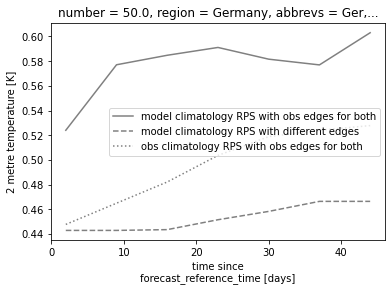

In [107]:
# view results
clim_rps_m1e.t2m.plot(c='gray',label='model climatology RPS with obs edges for both')
clim_rps_m2e.t2m.plot(c='gray', ls='--', label='model climatology RPS with different edges')
clim_rps_o1.t2m.plot(c='gray', ls=':', label='obs climatology RPS with obs edges for both')
plt.legend()

### Overview

Text(0.5, 1.0, 'RPS for Germany by forecast model ECMWF biweekly averaged')

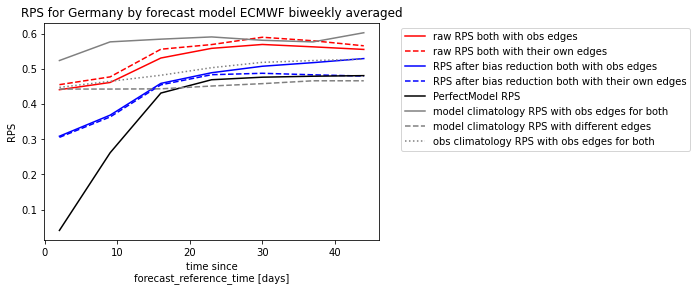

In [108]:
rps_raw_1e.t2m.plot(c='r', label='raw RPS both with obs edges')
rps_raw_2e.t2m.plot(c='r', ls='--', label='raw RPS both with their own edges')
rps_bias_reduced_1e.t2m.plot(c='b', label='RPS after bias reduction both with obs edges')
rps_bias_reduced_2e.t2m.plot(c='b', ls='--', label='RPS after bias reduction both with their own edges')
rps_pm.t2m.plot(c='k', label='PerfectModel RPS')
clim_rps_m1e.t2m.plot(c='gray', label='model climatology RPS with obs edges for both')
clim_rps_m2e.t2m.plot(c='gray', ls='--', label='model climatology RPS with different edges')
clim_rps_o1.t2m.plot(c='gray', ls=':', label='obs climatology RPS with obs edges for both')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('RPS')
plt.title(f'RPS for {region} by forecast model {model} biweekly averaged')

# Big data example

In [117]:
import numpy as np
import xarray as xr
import climpred
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
climpred.set_options(warn_for_failed_PredictionEnsemble_xr_call=False)

> The workflow with `climpred` workflow for small country data (MBs) and big geospatial data (10s GB) is identical.

> The only thing you need to take care of is [chunking](http://xarray.pydata.org/en/stable/user-guide/dask.html) and connecting to a [`NCARCluster`](https://github.com/NCAR/ncar-jobqueue).

In [118]:
# cluster started from cluster.ipynb via ncar_jobqueue.NCARCluster, adaptive `cluster.adapt(minimum_jobs=1,maximum_jobs=24)` more economical or scale `cluster.scale(jobs=12)`
from dask.distributed import Client
client = Client("tcp://10.12.206.63:33988") # exchange IP with what you get in cluster.ipynb

In [119]:
client

Client Scheduler: tcp://10.12.206.63:33988 Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/aspring/proxy/{port}/status,Cluster Workers: 2 Cores: 4 Memory: 50.00 GB


In [120]:
data_path = '/glade/scratch/jaye/S2S_zarr'
# load big geospatial data 
model = 'ECMWF' # ECCC, NCEP  # forecast model
type = 'anom' # raw # anom means anomaly and means that climatology is removed
dim = 'geospatial' # geospatial  # spatial aggregatation
lead = 'biweekly' # biweekly  # lead aggregation
init = xr.open_dataset(f'{data_path}/{model}.{type}.{lead}.{dim}.zarr', engine='zarr', chunks='auto')
obs = xr.open_dataset(f'{data_path}/CPC.zarr', engine='zarr', chunks='auto') # todo: need biweekly obs

In [121]:
# alternatively with intake
import intake
cat = intake.open_catalog('ASP_data_catalog.yml')
init = cat[model](data=data, lead=lead, dim=dim).to_dask()
obs = cat['obs'](data=data, lead=lead, dim=dim).to_dask()

# skill with `climpred`

In [122]:
v='t2m'

In [123]:
he = climpred.HindcastEnsemble(init).add_observations(obs)[[v]] # select only one variable

In [124]:
he.nbytes*1e-9, 'GB'

(5.927026384, 'GB')

In [125]:
rmse_kwargs = dict(metric='rmse', comparison='e2o', dim='init', alignment='maximize', skipna=True)

### over all inits

In [126]:
# time and init should have only one chunk if init is in dim
he = he.chunk({'time':-1,'lon':20}).chunk({'init':-1,'lead':1,'lon':20}).persist()

In [127]:
%time rmse = he.verify(**rmse_kwargs)

CPU times: user 3.96 s, sys: 14.9 ms, total: 3.97 s
Wall time: 4.08 s


In [128]:
rmse[v].data

dask.array<concatenate, shape=(3, 121, 240), dtype=float64, chunksize=(1, 121, 20), chunktype=numpy.ndarray>

In [129]:
# checkout dask parallelization in the dashboard
client.dashboard_link

'https://https://jupyterhub.hpc.ucar.edu/stable/user/aspring/proxy/{port}/status'

In [130]:
%time rmse = rmse.compute()

CPU times: user 78.4 ms, sys: 2.28 ms, total: 80.6 ms
Wall time: 22.7 s


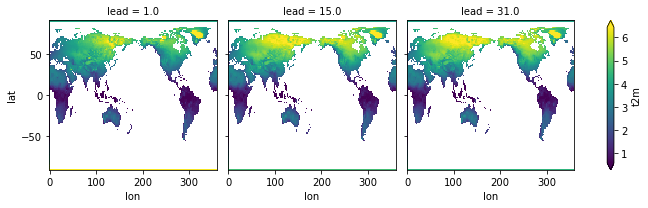

In [131]:
rmse[v].plot(col='lead', robust=True)

### over seasons

In [132]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [133]:
rmse_seasons = []
label_seasons = []
# Loops through all inits for a given season.
for label_season, group in tqdm(he.get_initialized().groupby("init.season")):
    # select only season inits
    rmse_season = he.sel(init=group.init).verify(**rmse_kwargs)
    rmse_seasons.append(rmse_season)
    label_seasons.append(label_season)
rmse_seasons = xr.concat(rmse_seasons, dim="season").assign_coords(season=label_seasons)

100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


In [134]:
%time rmse_seasons = rmse_seasons.compute()

CPU times: user 145 ms, sys: 5.3 ms, total: 150 ms
Wall time: 3.93 s


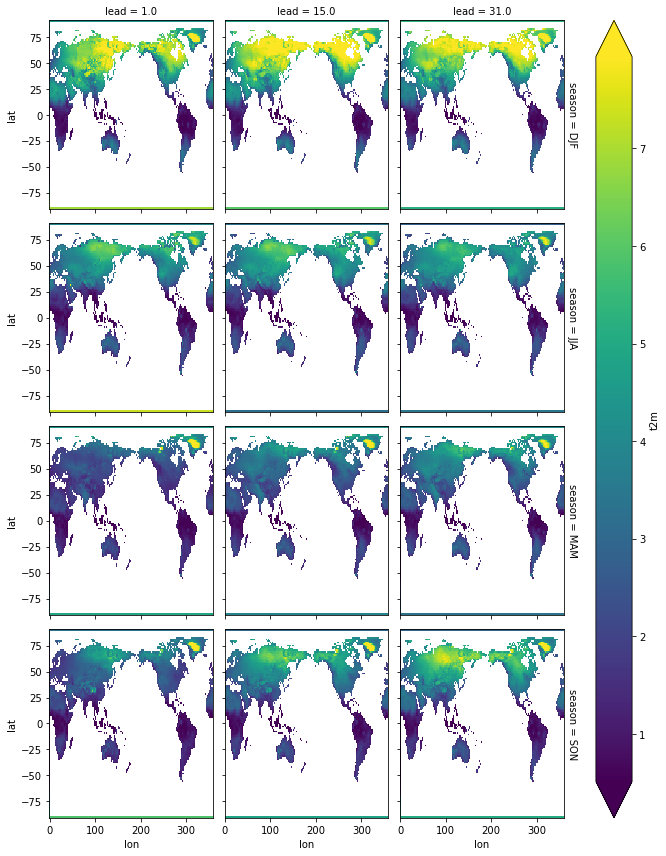

In [135]:
rmse_seasons[v].plot(col='lead', row='season', robust=True)

## `rps`

`category_edges` are precomputed

In [168]:
model = 'ECMWF' # ECCC, NCEP  # forecast model
data = 'anom' # raw # anom means anomaly and means that climatology is removed
dim = 'geospatial' # geospatial  # spatial aggregatation
lead = 'biweekly' # biweekly  # lead aggregation
model_edges = xr.open_dataset(f'/glade/scratch/jaye/S2S_zarr/{model}.{data}.cat_edges.{lead}.{dim}.zarr', engine='zarr', chunks='auto', decode_timedelta=False)
obs_edges = xr.open_dataset(f'/glade/scratch/jaye/S2S_zarr/OBS.{data}.cat_edges.{lead}.{dim}.zarr', engine='zarr', chunks='auto', decode_timedelta=False)

In [194]:
# alternatively with intake
import intake
cat = intake.open_catalog('ASP_data_catalog.yml')
model_edges = cat['cat_edges'](model=model, data=data, lead=lead, dim=dim).to_dask()
obs_edges = cat['cat_edges'](model='OBS', data=data, lead=lead, dim=dim).to_dask()

### `rps` with counting both forecasts and observations into observation bins

In [196]:
rps_kwargs = {'metric': 'rps', 'comparison':'m2o', 'dim':['init','member'], 'alignment':'maximize'}

In [197]:
# same category edges for forecast and observations, provide xr.Dataset
%time rps_1e = he.verify(category_edges=obs_edges, **rps_kwargs)

CPU times: user 4.1 s, sys: 17.6 ms, total: 4.12 s
Wall time: 4.31 s


In [198]:
# shouldnt have a month/dayofyear dimension
rps_1e[v]

<xarray.DataArray 't2m' (lead: 3, lat: 121, lon: 240)>
dask.array<concatenate, shape=(3, 121, 240), dtype=float64, chunksize=(1, 121, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat                         (lat) float64 90.0 88.5 87.0 ... -88.5 -90.0
  * lead                        (lead) float64 1.0 15.0 31.0
  * lon                         (lon) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    observations_category_edge  <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    forecasts_category_edge     <U101 '[-np.inf, 0.3333333333333333), [0.3333...
    skill                       <U11 'initialized'
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  240
    GRIB_Ny:                                  121
    GRIB_cfName:                              air_temperature
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            pf
    ...                                       ...
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_units:                               K
    cell_method:                              lead_time: average
    long_name:                                2 metre temperature
    standard_name:                            air_temperature
    units:                                    K

In [199]:
%time rps_1e = rps_1e.load()

CPU times: user 109 ms, sys: 10.7 ms, total: 120 ms
Wall time: 7.27 s


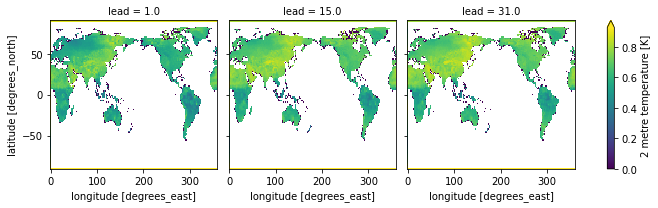

In [200]:
rps_1e[v].plot(col='lead', robust=True)

> lead-time dependent bias worsens rps for later lead weeks, if category edges of observations are used to bin the forecasting model

### `rps` with counting forecasts into forecast bins and observations into observation bin

In [201]:
# different category edges for forecast and observations, provide tuple of xr.Dataset
# doesnt work yet
rps_2e = he.verify(category_edges=(obs_edges, model_edges), **rps_kwargs)

In [202]:
%time rps_2e = rps_2e.load()

CPU times: user 112 ms, sys: 3.6 ms, total: 116 ms
Wall time: 9.61 s


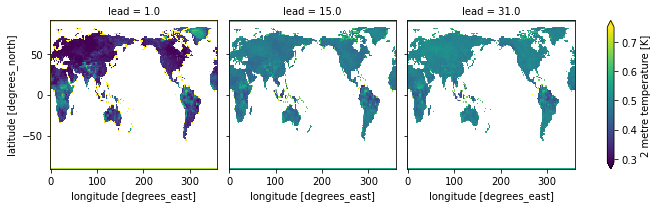

In [203]:
rps_2e[v].plot(col='lead', robust=True)

> I expected rps now much better for later leads now, because forecast bins inherently correct lead-time dependent bias.

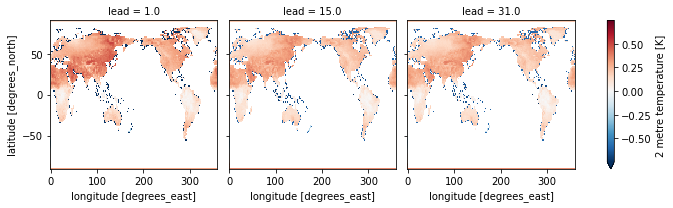

In [204]:
# smaller rps better: red means rps_2e better than rps
(rps_1e - rps_2e)[v].plot(col='lead', robust=True, cmap='RdBu_r')

# category_edges by hand

- can be precomputed
- groupby takes ages, map_blocks may speed up: https://nbviewer.jupyter.org/gist/rabernat/30e7b747f0e3583b5b776e4093266114
- `quantile(skipna=False)` much faster than `quantile(skipna=True)`: factor ~30
- for now creates tercile edges from `month`ly climatology, could also be daily `dayofyear` or weekly (more difficult via pandas) `weekofyear`

In [38]:
groupby_time = 'month' # 'month' 'dayofyear'

#### observations

In [39]:
%time obs_edges = obs.chunk({'time':-1,'lon':'auto'}).groupby(f'time.{groupby_time}').quantile(q=[1./3.,2./3.], dim='time', skipna=False).rename({'quantile':'category_edge'}).astype('float32').compute()

CPU times: user 961 ms, sys: 25.7 ms, total: 986 ms
Wall time: 16.2 s


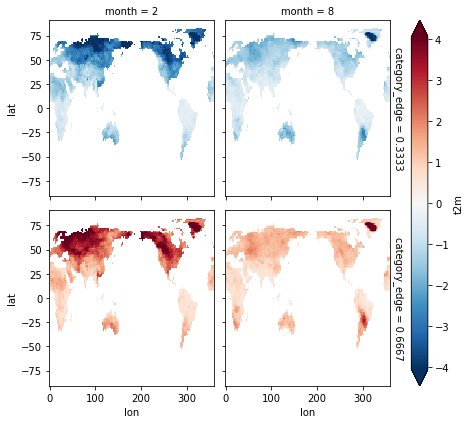

In [40]:
obs_edges[v].isel({groupby_time:[1,7]}).plot(row='category_edge', col=groupby_time, robust=True)

#### model

In [42]:
model_edges = he.get_initialized().groupby(f'init.{groupby_time}').quantile(q=[1./3.,2./3.], dim=['init','member'], skipna=False).rename({'quantile':'category_edge'}).astype('float32')
model_edges[v]

,Array,Chunk
Bytes,8.36 MB,19.36 kB
Shape,"(12, 2, 3, 121, 240)","(1, 2, 1, 121, 20)"
Count,3924 Tasks,432 Chunks
Type,float32,numpy.ndarray


In [43]:
%time model_edges = model_edges.load()

CPU times: user 680 ms, sys: 11.6 ms, total: 692 ms
Wall time: 23 s


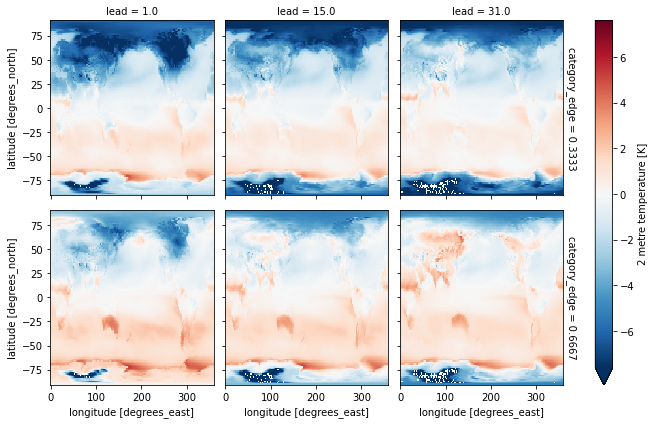

In [44]:
model_edges[v].isel({groupby_time:1}).plot(row='category_edge', col='lead', robust=True)

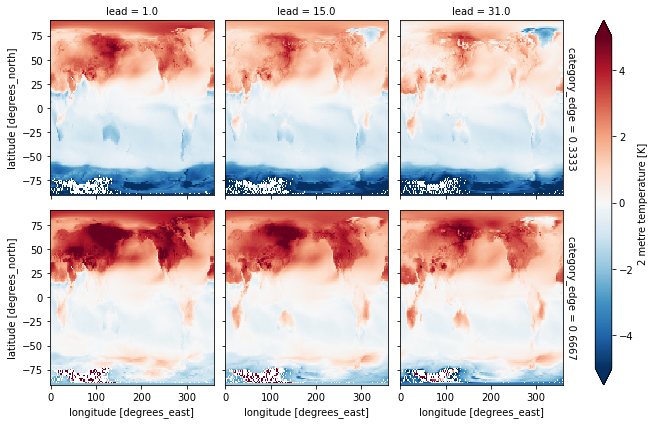

In [45]:
model_edges[v].isel({groupby_time:7}).plot(row='category_edge', col='lead', robust=True)

In [76]:
client.close()